# Import packages

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import skimage
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Constants

In [3]:
batch_size = 32                         # Batch size for training.
img_size = 64                           # image size
target_dim = (img_size, img_size, 3)    # (64, 64, 3)
num_classes = 29                        # 29 classes, 27 letters, 1 space, 1 delete, 1 nothing

img_count = 87000
train_dir = 'C:/Users/Krow/Documents/Uni/PI/archive/asl_alphabet_train/asl_alphabet_train/'
test_dir = 'C:/Users/Krow/Documents/Uni/PI/archive/asl_alphabet_test/asl_alphabet_test/' 

# Load Dataset

In [4]:


def get_data(data_dir) :
    images = []
    labels = []
    
    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Obtaining images of", dir_list[i], "...")
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(i)
    
    return images, labels

def preprocess_data(X, y):
    np_X = np.array(X)
    normalised_X = np_X.astype('float32')/255.0
    
    label_encoded_y = utils.to_categorical(y)
    
    x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded_y,random_state=42)
    
    return x_train, x_test, y_train, y_test


In [5]:


X, y = get_data(train_dir)

x_train, x_test, y_train, y_test = preprocess_data(X, y)


Obtaining images of A ...
Obtaining images of B ...
Obtaining images of C ...
Obtaining images of D ...
Obtaining images of del ...
Obtaining images of E ...
Obtaining images of F ...
Obtaining images of G ...
Obtaining images of H ...
Obtaining images of I ...
Obtaining images of J ...
Obtaining images of K ...
Obtaining images of L ...
Obtaining images of M ...
Obtaining images of N ...
Obtaining images of nothing ...
Obtaining images of O ...
Obtaining images of P ...
Obtaining images of Q ...
Obtaining images of R ...
Obtaining images of S ...
Obtaining images of space ...
Obtaining images of T ...
Obtaining images of U ...
Obtaining images of V ...
Obtaining images of W ...
Obtaining images of X ...
Obtaining images of Y ...
Obtaining images of Z ...


x_train shape: (65250, 64, 64, 3) y_train shape: (65250, 29)


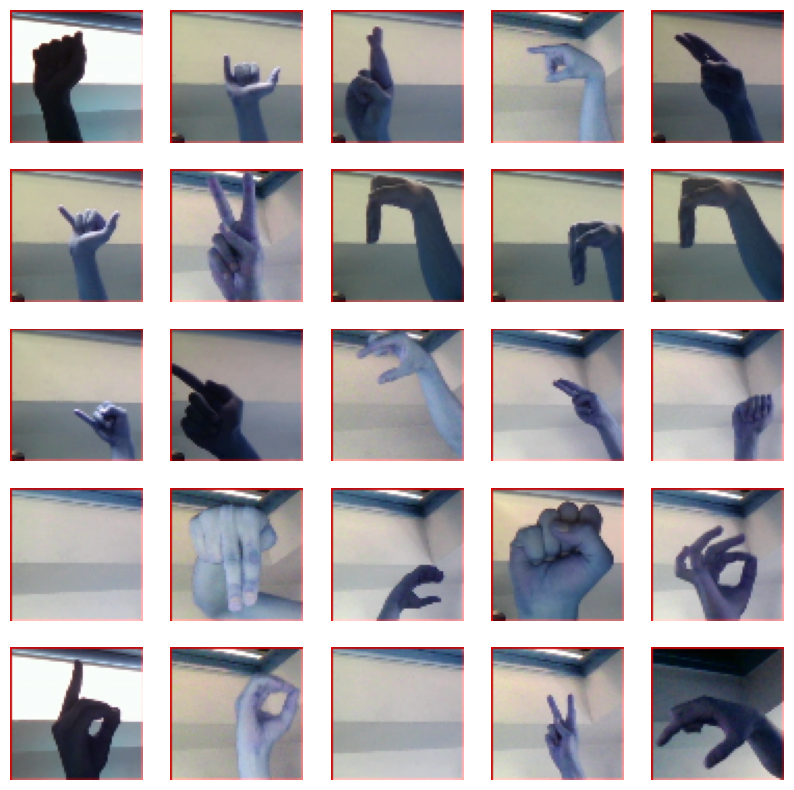

In [6]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# fetch 25 random images from the training set
random_images = np.random.randint(0, x_train.shape[0], size=25)
plt.figure(figsize=(10,10))
for i, index in enumerate(random_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[index])
    plt.axis('off')
plt.show()

# Generating train and test data

# One Hot Encoding

In [7]:
y_categorical_train = to_categorical(y_train, num_classes)
y_categorical_val = to_categorical(y_test, num_classes)

# Model

In [8]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                        

# Early Stopping

In [9]:
early_stop_critterion = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model Fitting

In [10]:
model.fit(x_train, 
        y_train, 
        batch_size=batch_size,
        epochs=15,
        verbose=1,
        validation_split=0.2,
        shuffle=True,
        #callbacks=[early_stop_critterion]
    )

Epoch 1/15
1632/1632 [==============================] - 33s 16ms/step - loss: 0.8625 - accuracy: 0.7479 - val_loss: 0.3485 - val_accuracy: 0.8851
Epoch 2/15
1632/1632 [==============================] - 25s 15ms/step - loss: 0.1706 - accuracy: 0.9464 - val_loss: 0.2351 - val_accuracy: 0.9307
Epoch 3/15
1632/1632 [==============================] - 25s 16ms/step - loss: 0.1012 - accuracy: 0.9705 - val_loss: 0.1939 - val_accuracy: 0.9448
Epoch 4/15
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0862 - accuracy: 0.9770 - val_loss: 0.2792 - val_accuracy: 0.9331
Epoch 5/15
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0830 - accuracy: 0.9789 - val_loss: 0.1742 - val_accuracy: 0.9523
Epoch 6/15
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0500 - accuracy: 0.9871 - val_loss: 0.9737 - val_accuracy: 0.8111
Epoch 7/15
1632/1632 [==============================] - 25s 16ms/step - loss: 0.0563 - accuracy: 0.9860 - val_loss: 0.2374 -

# Metric gathering

In [11]:
metrics = pd.DataFrame(model.history.history)
print("The metrics for the trained model are:")
metrics

The metrics for the trained model are:


,loss,accuracy,val_loss,val_accuracy
0,0.862453,0.747931,0.348518,0.885057
1,0.170567,0.946418,0.235125,0.930651
2,0.101172,0.970498,0.193872,0.944751
3,0.086202,0.976954,0.279170,0.933103
4,0.082986,0.978927,0.174231,0.952337
5,0.050030,0.987107,0.973697,0.811111
6,0.056258,0.985996,0.237425,0.944061
7,0.059368,0.985785,0.223177,0.958084
8,0.046442,0.989215,0.058346,0.987280
9,0.034472,0.991877,0.293633,0.948276


In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

680/680 [==============================] - 4s 5ms/step - loss: 0.0736 - accuracy: 0.9822
Test accuracy: 0.9821609258651733
Test loss: 0.07360060513019562


# Graphs

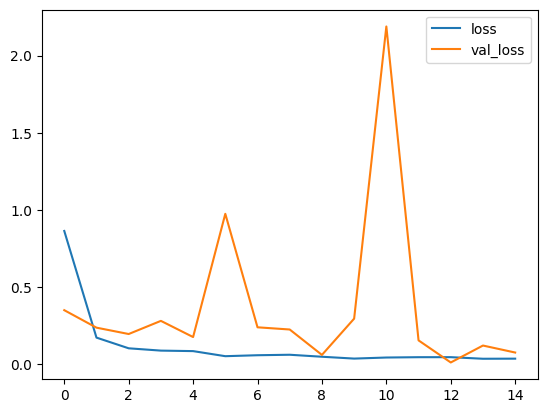

<AxesSubplot: >

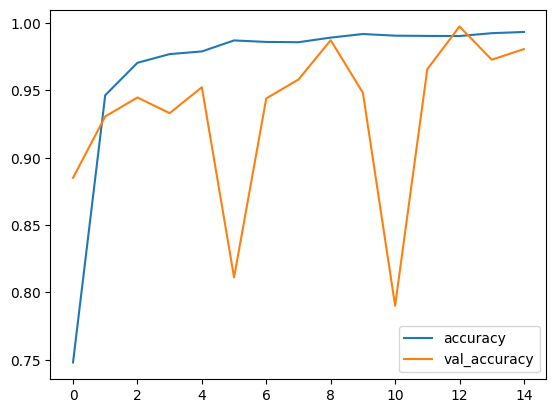

In [13]:
metrics[['loss', 'val_loss']].plot()
plt.show()

metrics[['accuracy', 'val_accuracy']].plot()

# Prediction

In [14]:
#predictions = model.predict_classes(x_test)

#print(classification_report(y_test, predictions))

# Confusion Matrix

#plt.figure(figsize=(12,12))
#sns.heatmap(confusion_matrix(y_test, predictions))
#plt.show()

# Saving    

In [15]:
from keras.models import load_model
model.save('asl_model.h5')